In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import matplotlib.dates as mdates
import re
import datetime
import scipy.interpolate as sci
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar

In [2]:
#ECMWF
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_sfc\.nc'

files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
files

data_ec = []
for file in files:
    file_path = os.path.join(directory, file)
    # Extract the date from the filename
    #date_str = re.search(r'\d{8}_\d{2}', file).group(0)
    #date = datetime.datetime.strptime(date_str, '%Y%m%d_%H').date()
    # Read the file and extract the desired variable
    ds = xr.open_dataset(file_path)
    variable_data = ds['t2m']

    #time_coord = xr.DataArray([date], dims='time1', coords={'time1': [date]})
    #variable_data = variable_data.expand_dims(dim='time1')
    #variable_data = variable_data.assign_coords(time=time_coord)

    data_ec.append(variable_data)

#combined_data = xr.concat(data, dim='time1')
#combined_data
#combined_data[0,:,119,234]
np.shape(data_ec)

#ds_ecmwf.t2m[0,79:159,194:274]
data_array_ec =xr.DataArray(data_ec)
data_array_ec_1 = data_array_ec[:,:,0:220,0:480]
np.shape(data_array_ec_1)

(21, 57, 220, 480)

In [3]:
#ERA5
ds_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/era5/2021.h5')
ds_era
ds_era_t2m = ds_era.fields[716,2,260:40:-1,720:1200]
ds_era_t2m

<xarray.DataArray 'fields' (phony_dim_2: 220, phony_dim_3: 480)>
[105600 values with dtype=float32]
Dimensions without coordinates: phony_dim_2, phony_dim_3

In [4]:
#climatology
#checking data
ds_clim_79_20 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/ry9527/clim_T2M_JJ_1979-2020_00UTC.nc',engine = 'netcdf4')
clim = ds_clim_79_20.T2M_clim[230:340,0:240]
clim

<xarray.DataArray 'T2M_clim' (latitude: 110, longitude: 240)>
[26400 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 25.0 25.5 26.0 26.5 ... 78.0 78.5 79.0 79.5
  * longitude  (longitude) float32 -180.0 -179.5 -179.0 ... -61.5 -61.0 -60.5
Attributes:
    long_name:  T2M_clim
    units:      K

In [5]:
#interpolate from (220,480) to (110,240) 
original_data = ds_era_t2m

# Define the original grid points along the last two dimensions
x_orig = np.arange(220)
y_orig = np.arange(480)

# Define the new grid points along the last two dimensions
y_new = np.linspace(0, 480 - 1, 240)  # Adjust the range to fit your specific needs
x_new = np.linspace(0, 220 - 1, 110)


# Perform the interpolation using xarray's interp function
new_data = original_data.interp(coords={'phony_dim_2': x_new, 'phony_dim_3': y_new}, method='linear')




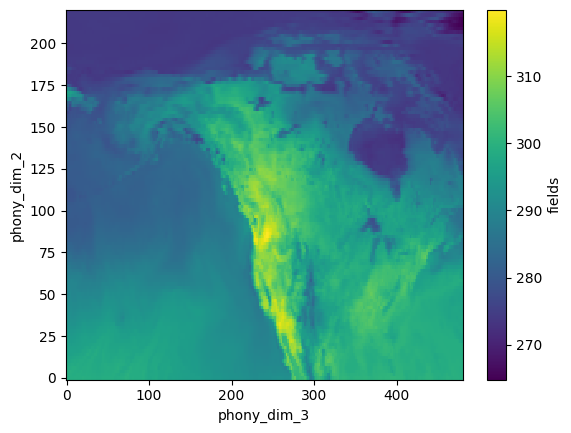

In [6]:
new_data.isel().plot()


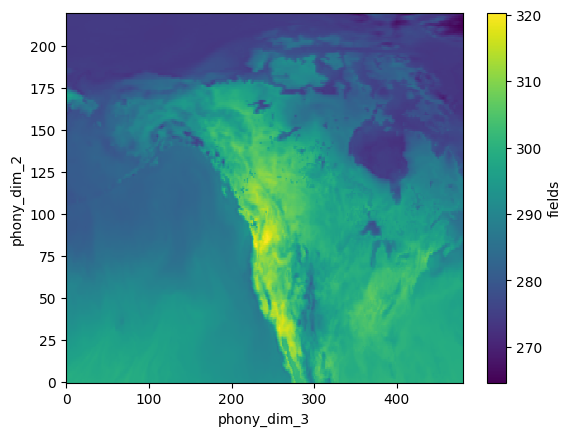

In [7]:
ds_era_t2m.isel().plot()

In [8]:


#use smaller batches to calculate the difference(cuz direct calculation is not possible)
variable1 = new_data.values
variable2 = clim[:,:].values


batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference = np.empty((110, 240))
for i in range(0, 110, batch_size):
    for j in range(0, 240, batch_size):
        batch_variable1 = variable1[i:i + batch_size, j:j + batch_size]
        batch_variable2 = variable2[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference = batch_variable1 - batch_variable2
        
        # Update the difference array with the current batch_difference
        difference[i:i + batch_size, j:j + batch_size] = batch_difference

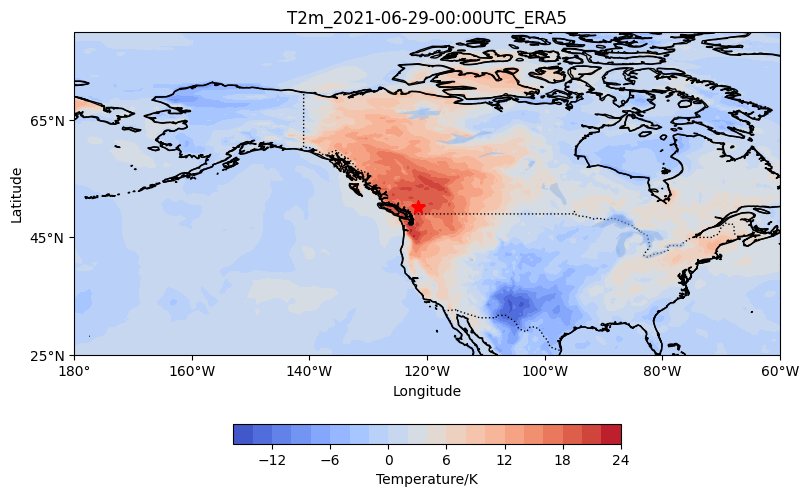

In [9]:
#plot the difference era5-clim

#lat = ds_clim_79_20['latitude']
#lon = ds_clim_79_20['longitude']

#lat= ds_era['phony_dim_2']
#lon= ds_era['phony_dim_3']
#phony_dim_2(260,40,-1)
#pholat= ds_era['phony_dim_2'][260:40:-1]ny_dim_3= slice(720,1200)

#ds_era.fields

#ds_era_tr = ds_era.transpose('phony_dim_0','phony_dim_1','phony_dim_3','phony_dim_2')

#lat= ds_era['phony_dim_2']
#lon= ds_era['phony_dim_3'][720:1200]

lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


#ds_era_t2m = ds_era.fields[660,2,260:40:-1,720:1200]


# Set the CARTOPY_USER_BACKGROUNDS environment variable
#os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/kit/imk-tro/gj5173/'

# Assuming you have latitude ('lat'), longitude ('lon'), and temperature ('temperature') variables

# Create a figure and axis with Cartopy projection
fig = plt.figure(figsize=(10,6))
#proj = ccrs.PlateCarree(central_longitude=-120)
#ax = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax = plt.axes(projection=ccrs.PlateCarree())
#proj = ccrs.PlateCarree(central_longitude=-120) 


# Set up the map projection
#projection = 'merc'  # Choose the desired projection
#fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree() })

# Convert coordinates to map projection
x, y = lon_grid, lat_grid  # Replace with the appropriate transformation method






leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent

#f2_ax1 = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  


# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
red_point_lon = -121.50
red_point_lat = 50.25
ax.plot(red_point_lon, red_point_lat, 'r*', markersize=10)
rect = patches.Rectangle((40.25,-131.50),20,20, linewidth=1, edgecolor='r', facecolor='r')

# Add the patch to the Axes
ax.add_patch(rect)
# Plot the contour map
#contour = ax.contourf(lon,lat,ds_era.fields[656,2,260:40:-1,720:1200],cmap='jet',levels=20)

contour1 = ax.contourf(x,y, difference,cmap='coolwarm',levels=20)


rightllon = -111.50
leftllon = -131.50
topllat = 60.25
bottomllat = 40.25


#ax.plot.Rectangle( (40.25,-131.50),20,20,linewidth=2, edgecolor='red')
#plt.gca().add_patch(red_box)

#mark the location of lytton
#red_point_lon = -121.50
#red_point_lat = 50.25
#ax.plot(red_point_lon, red_point_lat, 'r*', markersize=10)
# Add colorbar
#plt.colorbar()
cbar = plt.colorbar(contour1, ax=ax, label='Temperature/K',orientation='horizontal',shrink=0.5)
#red_box = plt.Rectangle((-2, -2), 2, 2, linewidth=2, edgecolor='red', facecolor='none')
#plt.gca().add_patch(red_box)


# Set plot title and labels
plt.title('T2m_2021-06-29-00:00UTC_ERA5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/T2m_2021-06-15_ERA5.png', bbox_inches='tight',dpi=100)

#656:2021.06.14 00UTC -06.29 00UTC
plt.show()
# Show the plot

In [10]:
levels = np.arange(-20,25,5)
levels

array([-20, -15, -10,  -5,   0,   5,  10,  15,  20])

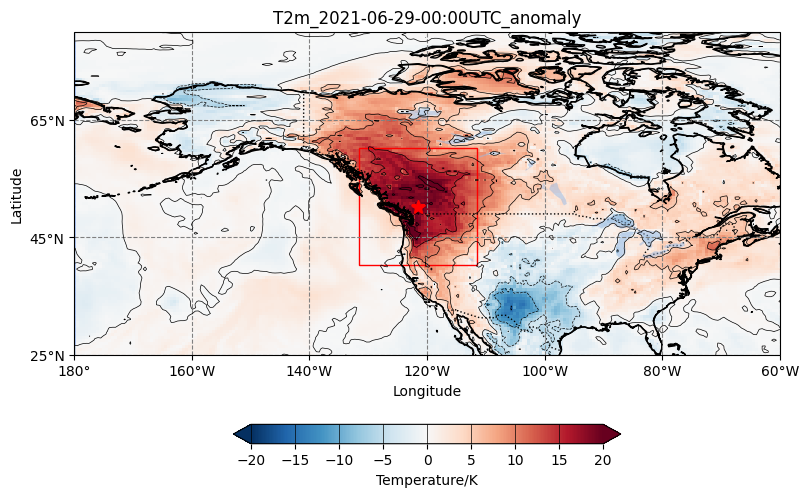

In [13]:
#plot the difference era5-clim

#lat = ds_clim_79_20['latitude']
#lon = ds_clim_79_20['longitude']

#lat= ds_era['phony_dim_2']
#lon= ds_era['phony_dim_3']
#phony_dim_2(260,40,-1)
#pholat= ds_era['phony_dim_2'][260:40:-1]ny_dim_3= slice(720,1200)

#ds_era.fields

#ds_era_tr = ds_era.transpose('phony_dim_0','phony_dim_1','phony_dim_3','phony_dim_2')

#lat= ds_era['phony_dim_2']
#lon= ds_era['phony_dim_3'][720:1200]

lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


#ds_era_t2m = ds_era.fields[660,2,260:40:-1,720:1200]


# Set the CARTOPY_USER_BACKGROUNDS environment variable
#os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/kit/imk-tro/gj5173/'

# Assuming you have latitude ('lat'), longitude ('lon'), and temperature ('temperature') variables

# Create a figure and axis with Cartopy projection
fig = plt.figure(figsize=(10,6))
#proj = ccrs.PlateCarree(central_longitude=-120)
#ax = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax = plt.axes(projection=ccrs.PlateCarree())
#proj = ccrs.PlateCarree(central_longitude=-120) 


# Set up the map projection
#projection = 'merc'  # Choose the desired projection
#fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree() })

# Convert coordinates to map projection
x, y = lon_grid, lat_grid  # Replace with the appropriate transformation method






leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent

#f2_ax1 = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  


# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


levels = np.arange(-20,25,5)
#levels = np.arange(difference.min(),difference.max(),20)
contour1 = ax.contourf(x,y, difference,cmap = 'coolwarm',levels = 10)

#vmin=difference.min(), vcenter=0, vmax=difference.max()
CS = plt.contour(x, y, difference, levels=levels,colors='k',linewidths =0.5)
#plt.clabel(CS, inline=1, fontsize=10)
red_point_lon = -121.50
red_point_lat = 50.25
ax.plot(red_point_lon, red_point_lat, 'r*', markersize=10)
rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes

# Plot the contour map
#contour = ax.contourf(lon,lat,ds_era.fields[656,2,260:40:-1,720:1200],cmap='jet',levels=20)

#contour1 = ax.contourf(x,y, difference,cmap='coolwarm',levels=20)


rightllon = -111.50
leftllon = -131.50
topllat = 60.25
bottomllat = 40.25


#ax.plot.Rectangle( (40.25,-131.50),20,20,linewidth=2, edgecolor='red')
#plt.gca().add_patch(red_box)

#mark the location of lytton
#red_point_lon = -121.50
#red_point_lat = 50.25
#ax.plot(red_point_lon, red_point_lat, 'r*', markersize=10)
# Add colorbar
#plt.colorbar()


#cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
#cbar = plt.colorbar(contour1, spacing='uniform')
#red_box = plt.Rectangle((-2, -2), 2, 2, linewidth=2, edgecolor='red', facecolor='none')
#plt.gca().add_patch(red_box)

#ax, fig = mpl.colorbar.make_axes(plt.gca(), shrink=0.5)
#cbar = mpl.colorbar.ColorbarBase(ax, cmap='coolwarm',
                       #norm=mpl.colors.Normalize(vmin=-15, vmax=15))
#cbar.set_clim(-20.0, 20.0)
#cmap = mcolors.LinearSegmentedColormap.from_list('centered_coolwarm', ['blue', 'white', 'red'])
# Add a colorbar
#cbar = plt.colorbar(contour1, ticks=[vmin, 0, vmax],ax=ax, label='Temperature/K',orientation='horizontal',shrink=0.5)
#cbar.set_label('K')


#norm = mcolors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=difference.max())
norm = mcolors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
pc = plt.pcolormesh(x,y,difference, norm=norm, cmap="RdBu_r")
cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
cb.add_lines(CS) 
# Customize the color of the colorbar tick labels
ax.add_patch(rect)






#tick_levels = np.linspace(difference.min(), difference.max(), 10)

# Create a custom colorbar with tick locations matching contour lines
#cax = plt.gca().inset_axes([0.95, 0.1, 0.03, 0.8])  # Adjust position and size as needed
#cb = mcolorbar.ColorbarBase(cax, cmap='coolwarm', boundaries=tick_levels, extend='both')

# Add contour lines to the colorbar
#cb.add_lines(CS)


#contour_levels = CS.levels

# Set colorbar boundaries to match contour levels
#cb = mcolorbar.ColorbarBase(cax, cmap='coolwarm', boundaries=[-np.inf] + contour_levels + [np.inf])
#cb.add_lines(contour_lines)  # Add contour lines to the colorbar









# Set plot title and labels
plt.title('T2m_2021-06-29-00:00UTC_anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.savefig('/home/kit/imk-tro/gj5173/29.08_modified/T2m_2021-06-29_ERA5_anomaly.png', bbox_inches='tight',dpi=100)

#656:2021.06.14 00UTC -06.29 00UTC
plt.show()
# Show the plot

In [ ]:
#2021 summer tmax anomaly
#Time evolution of max temperature anomolies in summer 2021 averaged over the 20*20 box (era5)
#time evolution from 06-01 to 08-30





In [ ]:

plt.show()